$A_k$ からは $W_k^-, W_k^+$ という二つの区間重要度ベクトルが得られる.
これらは次の関係を満たす.

$$
\frac{W_{ki}^-}{W_{kj}^-} \subseteq A_{kij} \subseteq \frac{W_{ki}^+}{W_{kj}^+}
$$

$W_k^-, W_k^+$ から２重区間 PCM $\tilde{A}_k = \left( \tilde{A}_{kij}^-, \tilde{A}_{kij}^+ \right)$ を次のように計算することができる.

$$
\tilde{A}_{kij}^- = \frac{W_{ki}^-}{W_{kj}^-}, \quad
\tilde{A}_{kij}^+ = \frac{W_{ki}^+}{W_{kj}^+}, \quad
i, j \in \left\{ 1, \ldots, n \right\}, ~~ k \in \left\{ 1, 2 \right\}
$$

各種法での結合結果 $\mathscr{A} = \left( \mathscr{A}_{ij}^-, \mathscr{A}_{ij}^+ \right)$ とする.

$\left( \tilde{A}_{kij}^- \right)$ と $\left( \mathscr{A}_{kij}^- \right)$, 
$\left( \tilde{A}_{kij}^+ \right)$ と $\left( \mathscr{A}_{kij}^+ \right)$ の類似度を考える.


In [54]:
include("./crispPCM/index.jl")
include("./evaluation/index.jl")
include("./method1/index.jl")
include("./method2/index.jl")
include("./method3/index.jl")
include("./method4/index.jl")
include("./intervalPCM/index.jl")
include("./twofoldInterval/index.jl")
include("./twofoldIntervalPCM/index.jl")
include("./utils.jl")

discretizateIntoComparisonScale (generic function with 3 methods)

In [55]:
Random.seed!(100)

TaskLocalRNG()

In [56]:
S = 9.0
threshold = log(5) / 2

0.8047189562170501

In [57]:
SimulationCase = @NamedTuple{
    A₁::Matrix{Interval{T}},
    A₂::Matrix{Interval{T}}
} where {T <: Real}

function generateSimulationCases(
    n::Integer,
    numOfCrispPCM::Integer,
    intervalPCMsPerCrispPCM::Integer
)::Vector{SimulationCase}
    simulation_cases = SimulationCase[]

    for _ in 1:numOfCrispPCM
        # Generate a Crisp PCM
        crisp_pcm = generateConsistentCrispPCM(n, S)
        for _ in 1:intervalPCMsPerCrispPCM
            # Generate an Interval PCM for each Crisp PCM
            interval_pcm_1 = discretizateIntoComparisonScale(randamizedIntervalPCM(crisp_pcm, threshold), S)
            interval_pcm_2 = discretizateIntoComparisonScale(randamizedIntervalPCM(crisp_pcm, threshold), S)
            # Append the Crisp PCM and its corresponding Interval PCM as a tuple to the list
            push!(simulation_cases, (A₁=interval_pcm_1, A₂=interval_pcm_2))
        end
    end

    return simulation_cases
end

generateSimulationCases (generic function with 1 method)

In [58]:
SimulationResult = @NamedTuple{
    # 各 DM の与える区間 PCM
    A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}},
    # 各 DM の２重区間 PCM
    Ã₁::Matrix{TwofoldInterval{T}}, Ã₂::Matrix{TwofoldInterval{T}},
    Ã₁⁻::Matrix{Interval{T}}, Ã₂⁻::Matrix{Interval{T}},
    Ã₁⁺::Matrix{Interval{T}}, Ã₂⁺::Matrix{Interval{T}},
    # method 1 ~ 4 の二重区間 PCM
    𝓐¹::Matrix{TwofoldInterval{T}}, 𝓐²::Matrix{TwofoldInterval{T}},
    𝓐³::Matrix{TwofoldInterval{T}}, 𝓐⁴::Matrix{TwofoldInterval{T}},
    # 𝓐ᵏ の二重区間の内側の区間
    𝓐¹⁻::Matrix{Interval{T}}, 𝓐²⁻::Matrix{Interval{T}},
    𝓐³⁻::Matrix{Interval{T}}, 𝓐⁴⁻::Matrix{Interval{T}},
    # 𝓐ᵏ の二重区間の外側の区間
    𝓐¹⁺::Matrix{Interval{T}}, 𝓐²⁺::Matrix{Interval{T}},
    𝓐³⁺::Matrix{Interval{T}}, 𝓐⁴⁺::Matrix{Interval{T}},
    # エラーメッセージ
    error::String
} where {T <: Real}

methodList = [method1, method2, method3, method4]

function runSimulation(
    case::SimulationCase{T}
    )::SimulationResult{T} where {T <: Real}
    Ã₁=Ã(case.A₁); Ã₂=Ã(case.A₂)
    Ã₁⁻ = map(Ã₁ᵢⱼ -> Ã₁ᵢⱼ[1], Ã₁)
    Ã₁⁺ = map(Ã₁ᵢⱼ -> Ã₁ᵢⱼ[2], Ã₁)
    Ã₂⁻ = map(Ã₂ᵢⱼ -> Ã₂ᵢⱼ[1], Ã₂)
    Ã₂⁺ = map(Ã₂ᵢⱼ -> Ã₂ᵢⱼ[2], Ã₂)

    𝓐 = Dict(); 𝓐⁻ = Dict(); 𝓐⁺ = Dict()
    
    try
        for k in 1:4
            𝓐[k] = methodList[k](case.A₁, case.A₂)
            𝓐⁻[k] = map(𝓐ᵢⱼ -> 𝓐ᵢⱼ[1], 𝓐[k])
            𝓐⁺[k] = map(𝓐ᵢⱼ -> 𝓐ᵢⱼ[2], 𝓐[k])
        end

        return (
            A₁=case.A₁, A₂=case.A₂,
            Ã₁=Ã₁, Ã₂=Ã₂,
            Ã₁⁻=Ã₁⁻, Ã₂⁻=Ã₂⁻,
            Ã₁⁺=Ã₁⁺, Ã₂⁺=Ã₂⁺,
            𝓐¹=𝓐[1], 𝓐²=𝓐[2], 𝓐³=𝓐[3], 𝓐⁴=𝓐[4],
            𝓐¹⁻=𝓐⁻[1], 𝓐²⁻=𝓐⁻[2], 𝓐³⁻=𝓐⁻[3], 𝓐⁴⁻=𝓐⁻[4],
            𝓐¹⁺=𝓐⁺[1], 𝓐²⁺=𝓐⁺[2], 𝓐³⁺=𝓐⁺[3], 𝓐⁴⁺=𝓐⁺[4],
            error=""
        )
    catch e
        n = size(case.A₁, 2)
        IPCM = fill(1..1, n, n)
        twofoldIPCM = fill((1..1, 1..1), n, n)
        return (
            A₁=case.A₁, A₂=case.A₂,
            Ã₁=Ã₁, Ã₂=Ã₂,
            Ã₁⁻=Ã₁⁻, Ã₂⁻=Ã₂⁻,
            Ã₁⁺=Ã₁⁺, Ã₂⁺=Ã₂⁺,
            𝓐¹=twofoldIPCM, 𝓐²=twofoldIPCM, 𝓐³=twofoldIPCM, 𝓐⁴=twofoldIPCM,
            𝓐¹⁻=IPCM, 𝓐²⁻=IPCM, 𝓐³⁻=IPCM, 𝓐⁴⁻=IPCM,
            𝓐¹⁺=IPCM, 𝓐²⁺=IPCM, 𝓐³⁺=IPCM, 𝓐⁴⁺=IPCM,
            error=string(e)
        )
    end
end

runSimulation (generic function with 1 method)

In [59]:
InnerConincidenceList = @NamedTuple{
    𝓐¹⁻::T, 𝓐¹⁺::T,
    𝓐²⁻::T, 𝓐²⁺::T,
    𝓐³⁻::T, 𝓐³⁺::T,
    𝓐⁴⁻::T, 𝓐⁴⁺::T
} where {T <: Real}

ConincidenceList = @NamedTuple{
    A₁::InnerConincidenceList{T},
    A₂::InnerConincidenceList{T},
    error::String
} where {T <: Real}

function calculateCoincidenceList(result::SimulationResult{T})::ConincidenceList{T} where {T <: Real}
    Ã₁⁻ = result.Ã₁⁻; Ã₂⁻ = result.Ã₂⁻
    Ã₁⁺ = result.Ã₁⁺; Ã₂⁺ = result.Ã₂⁺
    𝓐¹⁻ = result.𝓐¹⁻; 𝓐¹⁺ = result.𝓐¹⁺
    𝓐²⁻ = result.𝓐²⁻; 𝓐²⁺ = result.𝓐²⁺
    𝓐³⁻ = result.𝓐³⁻; 𝓐³⁺ = result.𝓐³⁺
    𝓐⁴⁻ = result.𝓐⁴⁻; 𝓐⁴⁺ = result.𝓐⁴⁺
    try
        return (
            A₁=(
                𝓐¹⁻=logarithmicCoincidenceIndex(Ã₁⁻, 𝓐¹⁻), 𝓐¹⁺=logarithmicCoincidenceIndex(Ã₁⁺, 𝓐¹⁺),
                𝓐²⁻=logarithmicCoincidenceIndex(Ã₁⁻, 𝓐²⁻), 𝓐²⁺=logarithmicCoincidenceIndex(Ã₁⁺, 𝓐²⁺),
                𝓐³⁻=logarithmicCoincidenceIndex(Ã₁⁻, 𝓐³⁻), 𝓐³⁺=logarithmicCoincidenceIndex(Ã₁⁺, 𝓐³⁺),
                𝓐⁴⁻=logarithmicCoincidenceIndex(Ã₁⁻, 𝓐⁴⁻), 𝓐⁴⁺=logarithmicCoincidenceIndex(Ã₁⁺, 𝓐⁴⁺)
            ),
            A₂=(
                𝓐¹⁻=logarithmicCoincidenceIndex(Ã₂⁻, 𝓐¹⁻), 𝓐¹⁺=logarithmicCoincidenceIndex(Ã₂⁺, 𝓐¹⁺),
                𝓐²⁻=logarithmicCoincidenceIndex(Ã₂⁻, 𝓐²⁻), 𝓐²⁺=logarithmicCoincidenceIndex(Ã₂⁺, 𝓐²⁺),
                𝓐³⁻=logarithmicCoincidenceIndex(Ã₂⁻, 𝓐³⁻), 𝓐³⁺=logarithmicCoincidenceIndex(Ã₂⁺, 𝓐³⁺),
                𝓐⁴⁻=logarithmicCoincidenceIndex(Ã₂⁻, 𝓐⁴⁻), 𝓐⁴⁺=logarithmicCoincidenceIndex(Ã₂⁺, 𝓐⁴⁺)
            ),
            error=""
        )
    catch e
        return (
            A₁=(
                𝓐¹⁻=NaN, 𝓐¹⁺=NaN,
                𝓐²⁻=NaN, 𝓐²⁺=NaN,
                𝓐³⁻=NaN, 𝓐³⁺=NaN,
                𝓐⁴⁻=NaN, 𝓐⁴⁺=NaN
            ),
            A₂=(
                𝓐¹⁻=NaN, 𝓐¹⁺=NaN,
                𝓐²⁻=NaN, 𝓐²⁺=NaN,
                𝓐³⁻=NaN, 𝓐³⁺=NaN,
                𝓐⁴⁻=NaN, 𝓐⁴⁺=NaN
            ),
            error=string(e)
        )
    end
end

calculateCoincidenceList (generic function with 2 methods)

In [60]:
function total(conincidenceLists::Vector{ConincidenceList{T}}) where {T <: Real}
    if length(conincidenceLists) == 0
        throw(ArgumentError("Empty list of ConincidenceLists"))
    end

    list_σ¹⁻ = []; list_σ¹⁺ = []
    list_σ²⁻ = []; list_σ²⁺ = []
    list_σ³⁻ = []; list_σ³⁺ = []
    list_σ⁴⁻ = []; list_σ⁴⁺ = []

    count = 0

    for list in conincidenceLists
        if list.error != "" continue end

        push!(list_σ¹⁻, sqrt(list.A₁.𝓐¹⁻ * list.A₂.𝓐¹⁻))
        push!(list_σ¹⁺, sqrt(list.A₁.𝓐¹⁺ * list.A₂.𝓐¹⁺))
        push!(list_σ²⁻, sqrt(list.A₁.𝓐²⁻ * list.A₂.𝓐²⁻))
        push!(list_σ²⁺, sqrt(list.A₁.𝓐²⁺ * list.A₂.𝓐²⁺))
        push!(list_σ³⁻, sqrt(list.A₁.𝓐³⁻ * list.A₂.𝓐³⁻))
        push!(list_σ³⁺, sqrt(list.A₁.𝓐³⁺ * list.A₂.𝓐³⁺))
        push!(list_σ⁴⁻, sqrt(list.A₁.𝓐⁴⁻ * list.A₂.𝓐⁴⁻))
        push!(list_σ⁴⁺, sqrt(list.A₁.𝓐⁴⁺ * list.A₂.𝓐⁴⁺))
    end
    count *= 2

    return [
        list_σ¹⁻,
        list_σ²⁻,
        list_σ³⁻,
        list_σ⁴⁻,
        list_σ¹⁺,
        list_σ²⁺,
        list_σ³⁺,
        list_σ⁴⁺
    ]
end

total (generic function with 1 method)

In [64]:
function run(
    n::Integer, 
    numOfCrispPCM::Integer, 
    intervalPCMsPerCrispPCM::Integer
    )
    cases = generateSimulationCases(n, numOfCrispPCM, intervalPCMsPerCrispPCM)
    results = Vector{SimulationResult}(undef, length(cases))
    Threads.@threads for i in 1:length(cases)
        results[i] = runSimulation(cases[i])
    end
    conincidenceList = calculateCoincidenceList.(results)
    return total(conincidenceList)
end

run (generic function with 1 method)

In [65]:
r4 = run(4, 1000, 100)
r5 = run(5, 1000, 100)
r6 = run(6, 1000, 100)
r7 = run(7, 1000, 100)

8-element Vector{Vector{Any}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.6873780285127062, 0.6597961116317614, 0.682652971491966, 0.6833418206920815, 0.71712348169558, 0.6665914569180879, 0.7233502259271756, 0.7125541998645604, 0.7191061661905921, 0.7355735706064315  …  0.7592982398582997, 0.620762996054747, 0.723673168081704, 0.6647297857070904, 0.7739198889414233, 0.5994219245111779, 0.6989095330361009, 0.757615942224166, 0.6636701391782154, 0.7688486828177712]
 [0.776100603439942, 0.7914315714270241, 0.8430036476106862, 0.8110793528990323, 0.8482285058581036, 0.8735878941595361, 0.8337998351236587, 0.7647600

In [66]:
using Plots
using StatsPlots
using LaTeXStrings
pyplot()

Plots.PyPlotBackend()

In [67]:
function displayHistgram(result, y_max_inner, y_max_outer)
    list_p = []
    for i in eachindex(result)
        if i <= 4
            p = histogram(
                result[i],
                bins=range(0, stop=1, length=21),
                legend=false,
                xlims=(-0.1, 1),
                ylims=(0, y_max_inner),
                title=L"\tilde{\sigma}^{%$(i)-}"
            )
            push!(list_p, p)
        else
            p = histogram(
                result[i],
                bins=range(0, stop=1, length=21),
                legend=false,
                xlims=(-0.1, 1),
                ylims=(0, y_max_outer),
                title=L"\tilde{\sigma}^{%$(i-4)+}"
            )
            push!(list_p, p)
        end
    end
    display(plot(list_p..., layout=(2, 4), size=(1600, 800)))
end

displayHistgram (generic function with 1 method)

In [68]:
function displayBoxplot(result)
    list_p = []
    for i in eachindex(result)
        method_name = i <= 4 ? L"\tilde{\sigma}^{%$(i)-}" : L"\tilde{\sigma}^{%$(i-4)+}"
        p = boxplot(
            result[i],
            legend=false,
            xlims=(-0.1, 1),
            orientation=:horizontal,
            whisker_range=0,
            yticks=[],
            title=method_name
        )
        push!(list_p, p)
    end
    display(plot(list_p..., layout=(2, 4), size=(1600, 300)))
end

displayBoxplot (generic function with 1 method)

---
# $n = 4$

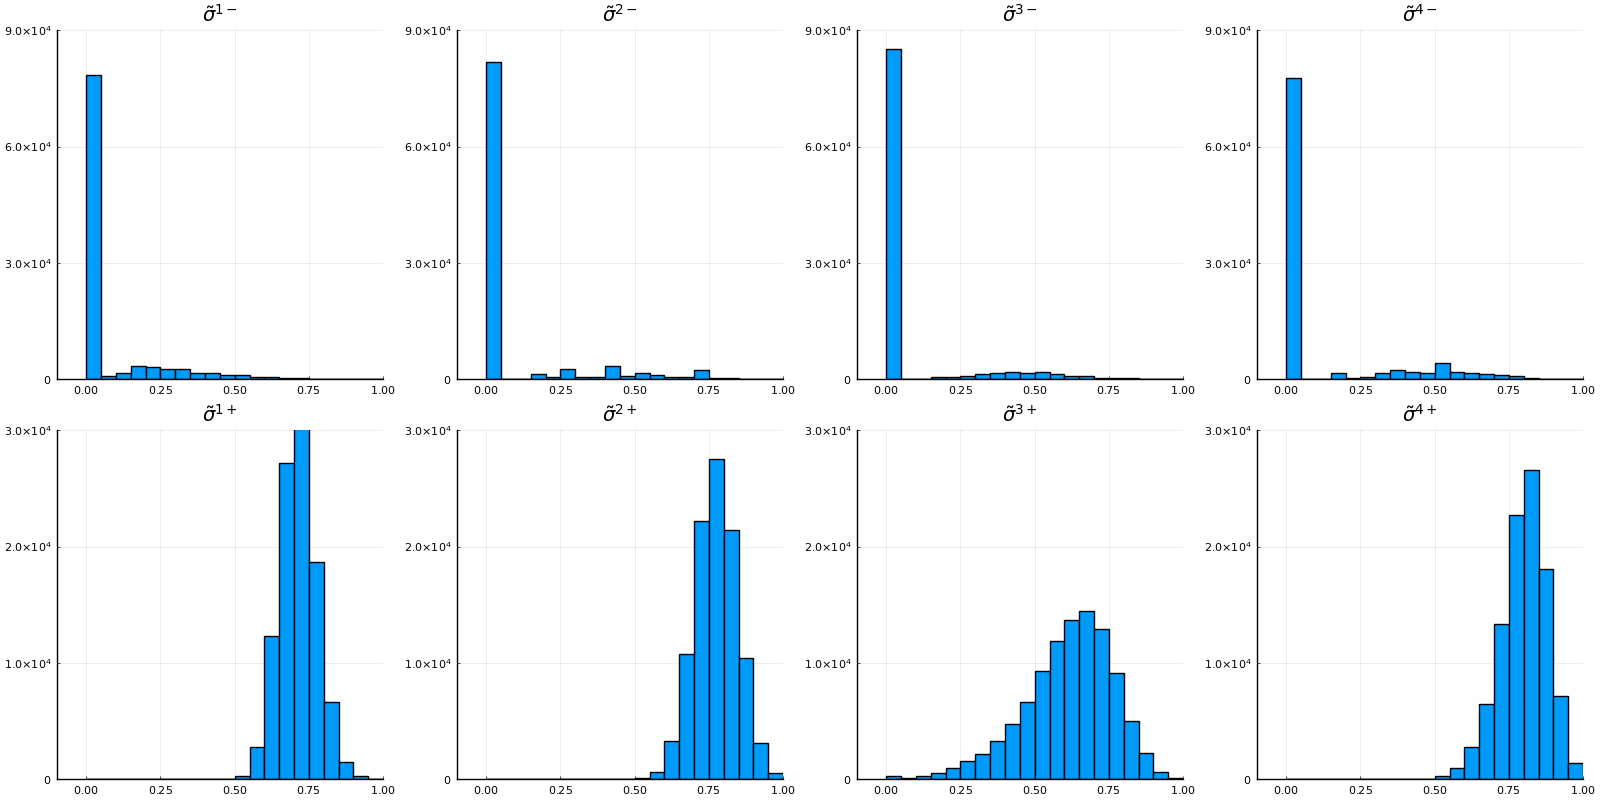

In [69]:
displayHistgram(r4, 9e4, 3e4)

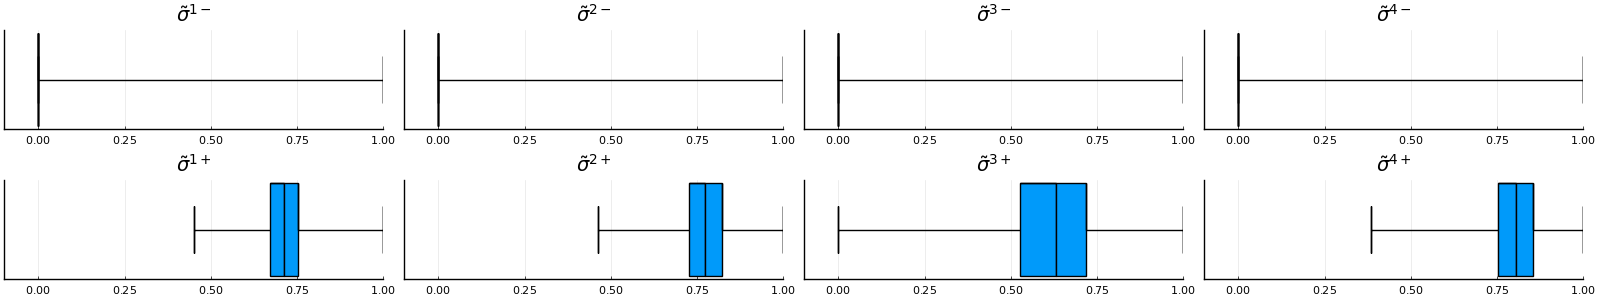

In [70]:
displayBoxplot(r4)

---
# $n = 5$

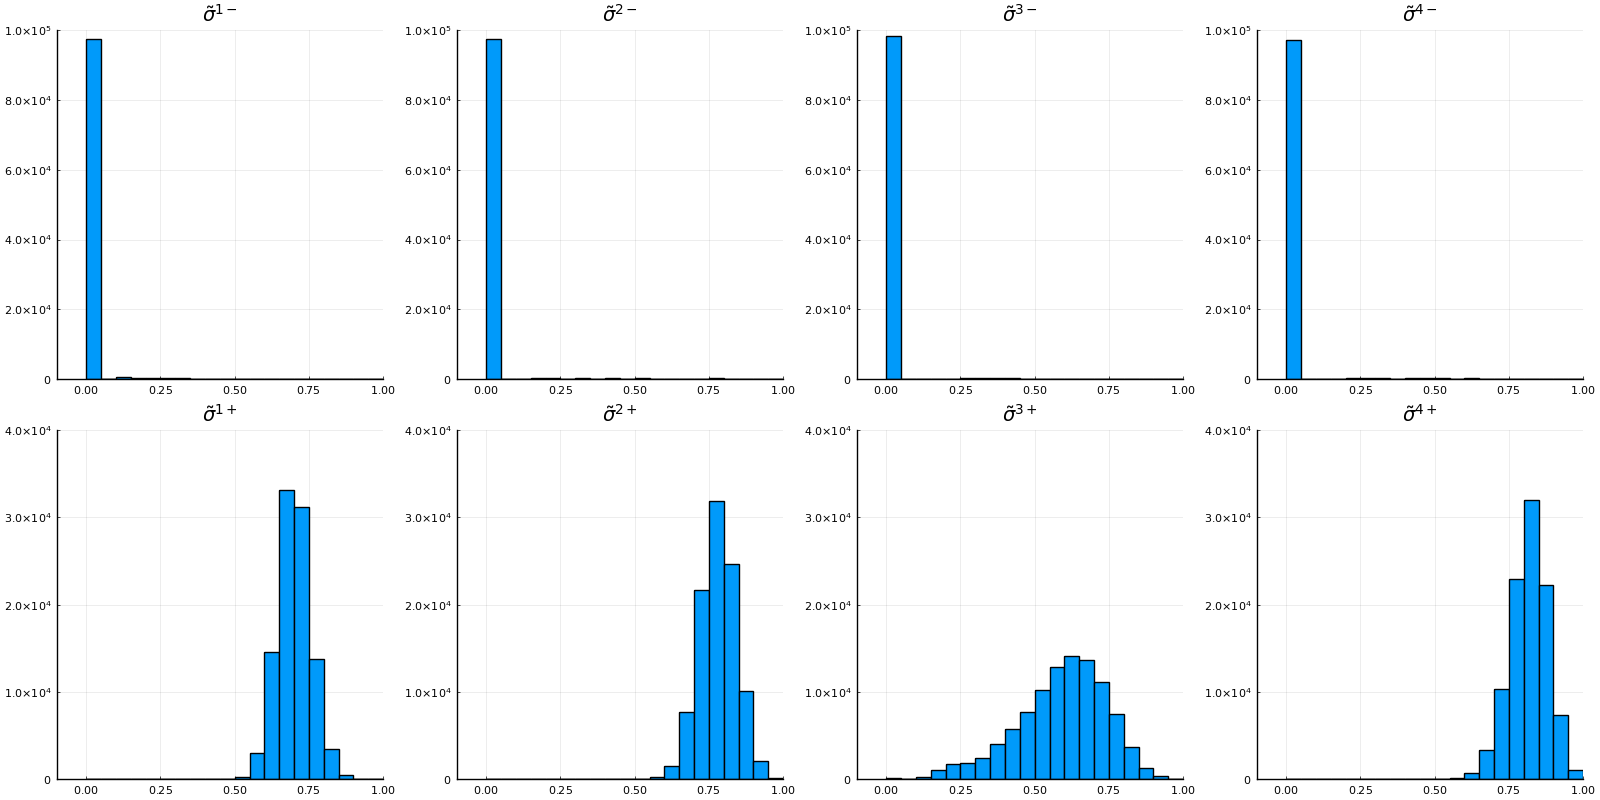

In [71]:
displayHistgram(r5, 1e5, 4e4)

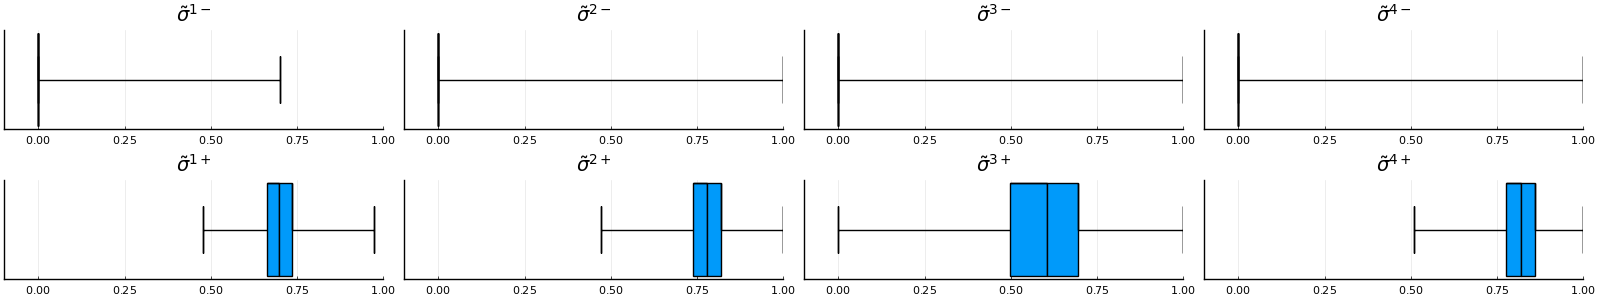

In [72]:
displayBoxplot(r5)

---
# $n = 6$

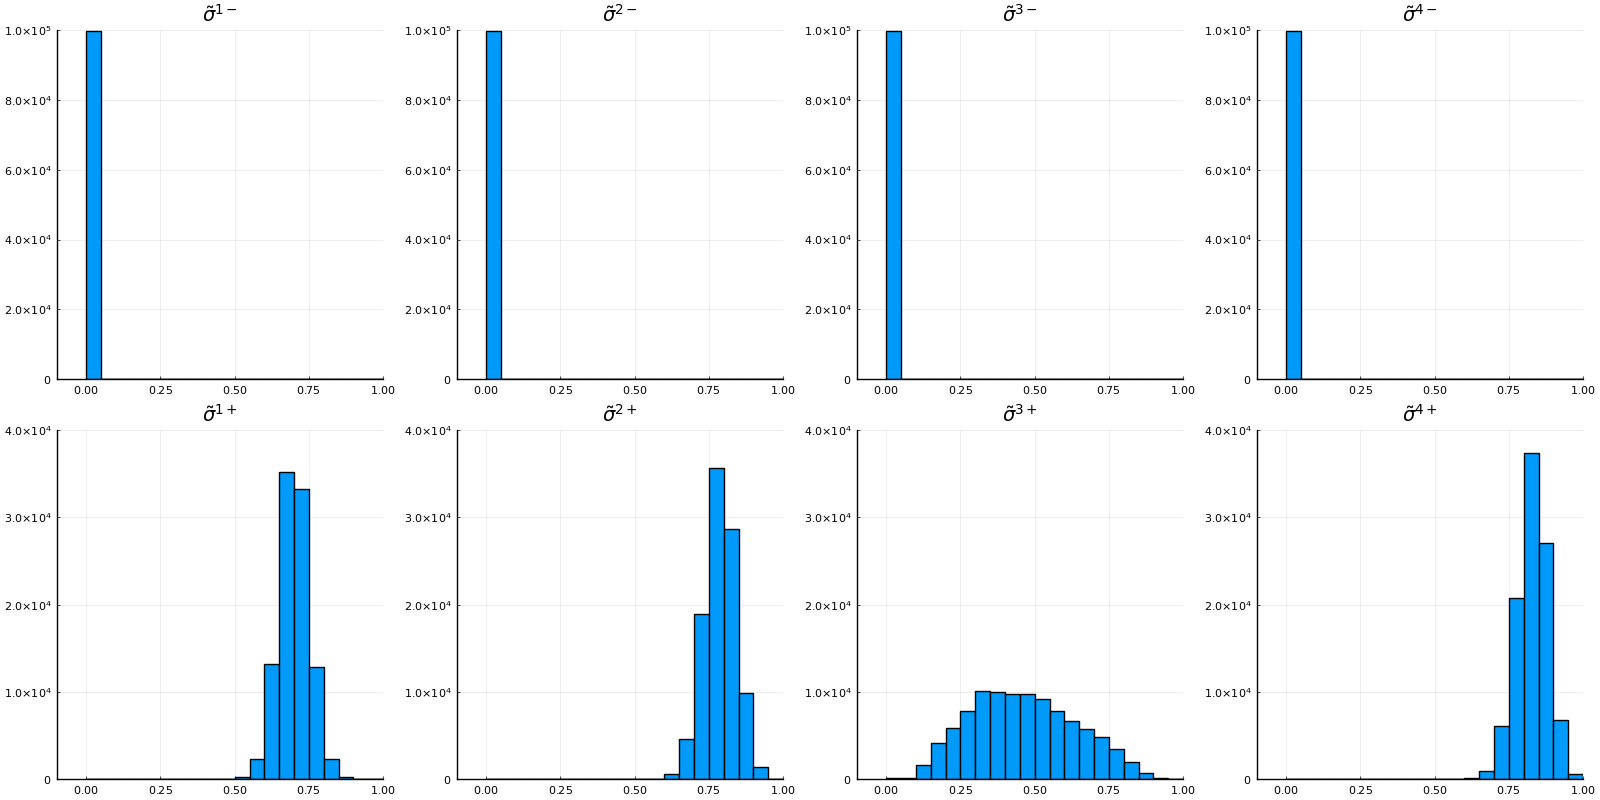

In [73]:
displayHistgram(r6, 1e5, 4e4)

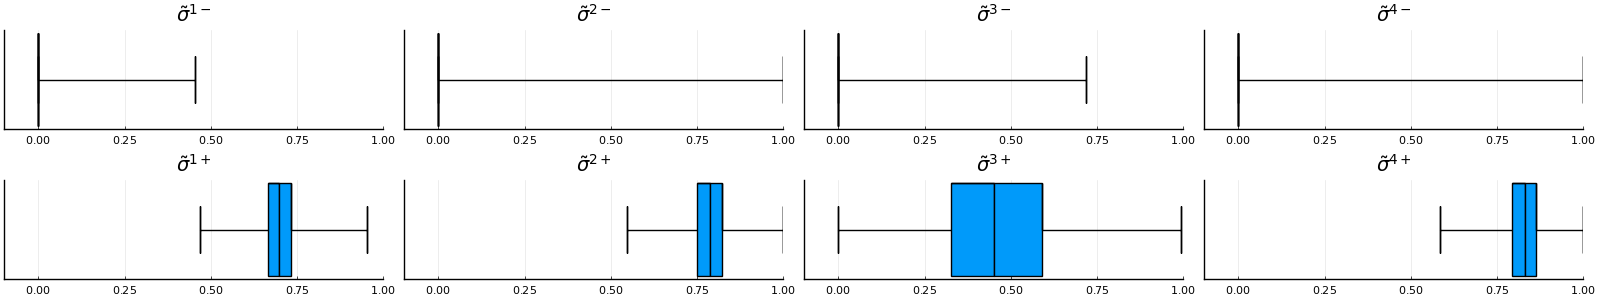

In [74]:
displayBoxplot(r6)

---
# $n = 7$

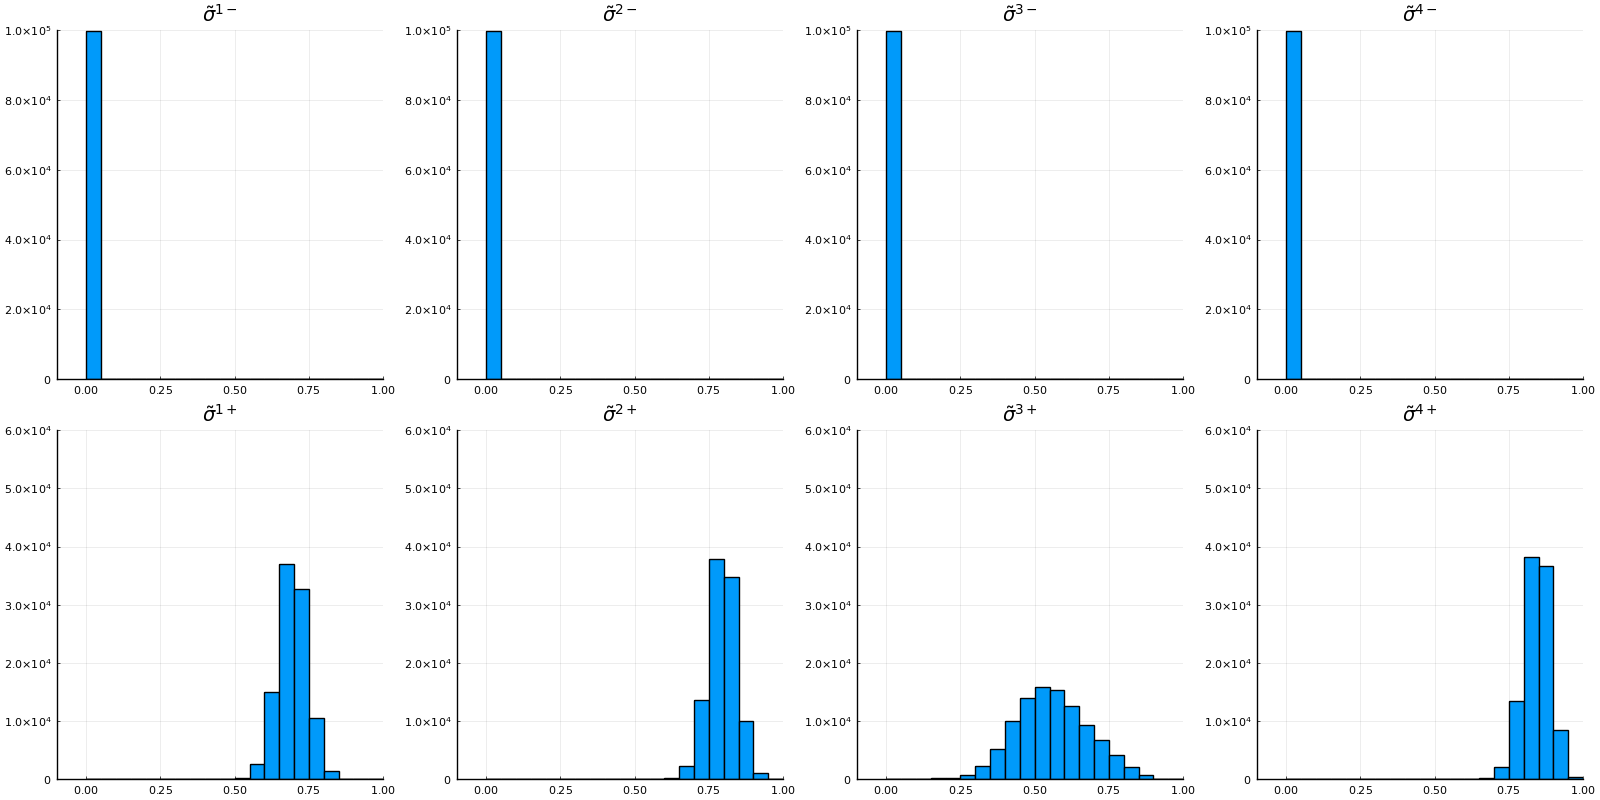

In [75]:
displayHistgram(r7, 1e5, 6e4)

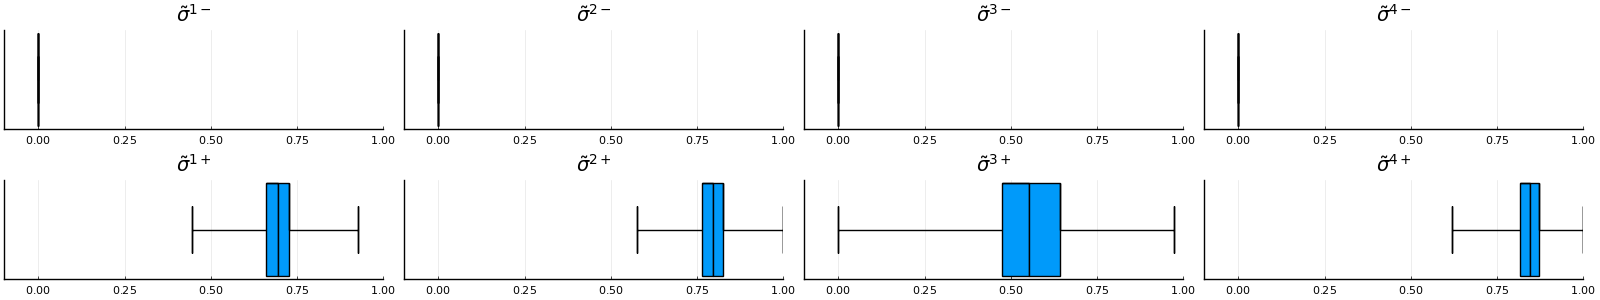

In [76]:
displayBoxplot(r7)